In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [4]:
!head ../input/third2/HPI_AT_state.csv

In [26]:
def read_at_state_hpi():
    df=pd.read_csv("../input/third2/HPI_AT_state.csv",header=None)
    df.columns=['state','year','quater','hpi']
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['hpi'].astype(np.float)
    df=df[df.year>2005]
    #df['HPI']=df['HPI'].astype(np.float32)
    #df=df[[u'State', u'Abbreviation', u'FIPS', u'Year' ,           u'HPI' ]]
    #assert df.Abbreviation.value_counts().value_counts().shape[0]==1
    df['t']=df['year']*100+df['quater']
    assert df.isnull().sum().sum()==0
    
    return df

In [27]:
state_at_hpi=read_at_state_hpi()

In [28]:
state_at_hpi.head()

state  year  quater     hpi       t
812    CA  2006       1  637.48  200601
813    CA  2006       2  643.17  200602
814    CA  2006       3  645.16  200603
815    CA  2006       4  641.20  200604
816    CA  2007       1  632.14  200701

In [29]:
state_at_hpi.dtypes

state      object
year        int64
quater      int64
hpi       float64
t           int64
dtype: object

In [30]:
state_at_hpi.state.value_counts().value_counts()

48    5
Name: state, dtype: int64

In [31]:
state_at_hpi.t.max()

201704

In [32]:
pv_at_state_hpi=pd.pivot_table(state_at_hpi, columns='t',values='hpi', index=['state'])

In [34]:
pv_at_state_hpi

t      200601  200602  200603  200604  200701  200702  200703  200704  200801  \
state                                                                           
CA     637.48  643.17  645.16  641.20  632.14  621.38  598.48  574.31  542.30   
IA     238.67  240.08  241.53  243.45  244.34  246.38  246.30  247.73  249.07   
NC     308.11  312.48  317.84  323.61  328.66  331.82  333.15  335.80  338.52   
NY     630.82  632.84  632.28  640.46  643.48  641.72  632.27  634.46  637.86   
OH     267.00  265.93  265.27  266.45  266.54  265.02  262.17  262.11  263.39   

t      200802   ...    201503  201504  201601  201602  201603  201604  201701  \
state           ...                                                             
CA     497.97   ...    535.14  542.74  549.59  559.27  570.57  579.37  591.06   
IA     247.75   ...    266.86  269.25  270.25  273.31  277.61  279.23  281.62   
NC     337.94   ...    323.44  326.59  331.28  336.40  343.50  345.55  348.11   
NY     626.06   ...    599.35  601.76  604.57  615.22  624.06  630.73  634.42   
OH     259.38   ...    253.97  255.10  256.37  261.10  266.62  266.36  267.36   

t      201702  201703  201704  
state                          
CA     605.04  616.61  626.90  
IA     286.01  290.94  292.67  
NC     360.80  364.47  365.96  
NY     645.36  658.07  663.05  
OH     277.18  281.41  281.82  

[5 rows x 48 columns]

In [36]:
!head ../input/third2/HPI_PO_state.txt

In [44]:
def read_po_state_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_state.txt" ,sep="\t")
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['index_nsa'].astype(np.float)
    df=df[df.yr>2005]
    df['t']=df['yr']*100+df['qtr']
    df=df.drop(['index_nsa','index_sa','Warning'],axis=1)
    assert df.isnull().sum().sum()==0
    return df

In [45]:
state_po_hpi=read_po_state_hpi()

In [47]:
state_po_hpi.head()

state    yr  qtr     hpi       t
492    CA  2006    1  285.92  200601
493    CA  2006    2  287.61  200602
494    CA  2006    3  282.69  200603
495    CA  2006    4  274.38  200604
496    CA  2007    1  271.89  200701

In [48]:
state_po_hpi.dtypes

state     object
yr         int64
qtr        int64
hpi      float64
t          int64
dtype: object

In [49]:
state_po_hpi.state.value_counts().value_counts()

48    5
Name: state, dtype: int64

In [50]:
state_po_hpi.t.max()

201704

In [51]:
pv_po_state_hpi=pd.pivot_table(state_po_hpi, columns='t',values='hpi', index=['state'])

In [56]:
pv_po_state_hpi.iloc[:,0]

state
CA    285.92
IA    192.64
NC    186.61
NY    214.92
OH    174.23
Name: 200601, dtype: float64

In [57]:
pv_po_state_hpi

t      200601  200602  200603  200604  200701  200702  200703  200704  200801  \
state                                                                           
CA     285.92  287.61  282.69  274.38  271.89  269.08  255.38  234.79  212.78   
IA     192.64  196.53  197.86  196.33  197.08  200.13  202.19  198.53  197.04   
NC     186.61  190.40  193.68  196.86  198.81  201.62  202.99  201.16  199.90   
NY     214.92  218.44  217.82  217.37  215.75  219.80  219.87  217.68  214.94   
OH     174.23  177.74  176.89  174.00  172.69  175.69  174.12  169.36  164.49   

t      200802   ...    201503  201504  201601  201602  201603  201604  201701  \
state           ...                                                             
CA     195.99   ...    231.44  234.20  237.61  244.79  248.39  250.42  255.56   
IA     198.86   ...    218.80  220.17  219.35  225.39  231.48  229.75  230.42   
NC     203.31   ...    204.75  204.29  207.62  213.52  217.62  218.91  220.58   
NY     215.34   ...    216.44  214.66  214.25  220.50  223.56  225.45  225.98   
OH     166.74   ...    174.60  173.44  173.54  181.03  184.33  183.32  183.69   

t      201702  201703  201704  
state                          
CA     265.60  270.16  271.67  
IA     236.00  240.31  239.91  
NC     231.73  231.06  233.78  
NY     231.05  236.89  238.87  
OH     192.55  195.83  194.89  

[5 rows x 48 columns]

In [84]:
a=pv_po_state_hpi.div(pv_po_state_hpi.iloc[:,0],axis=0)

In [85]:
a

t      200601    200602    200603    200604    200701    200702    200703  \
state                                                                       
CA        1.0  1.005911  0.988703  0.959639  0.950930  0.941102  0.893187   
IA        1.0  1.020193  1.027097  1.019155  1.023048  1.038881  1.049574   
NC        1.0  1.020310  1.037887  1.054927  1.065377  1.080435  1.087777   
NY        1.0  1.016378  1.013493  1.011400  1.003862  1.022706  1.023032   
OH        1.0  1.020146  1.015267  0.998680  0.991161  1.008380  0.999369   

t        200704    200801    200802    ...       201503    201504    201601  \
state                                  ...                                    
CA     0.821174  0.744194  0.685471    ...     0.809457  0.819110  0.831037   
IA     1.030575  1.022841  1.032288    ...     1.135797  1.142909  1.138652   
NC     1.077970  1.071218  1.089491    ...     1.097208  1.094743  1.112588   
NY     1.012842  1.000093  1.001954    ...     1.007072  0.998790  0.996883   
OH     0.972048  0.944097  0.957011    ...     1.002124  0.995466  0.996040   

t        201602    201603    201604    201701    201702    201703    201704  
state                                                                        
CA     0.856149  0.868740  0.875839  0.893816  0.928931  0.944880  0.950161  
IA     1.170006  1.201620  1.192639  1.196117  1.225083  1.247456  1.245380  
NC     1.144204  1.166175  1.173088  1.182037  1.241788  1.238197  1.252773  
NY     1.025963  1.040201  1.048995  1.051461  1.075051  1.102224  1.111437  
OH     1.039029  1.057969  1.052172  1.054296  1.105148  1.123974  1.118579  

[5 rows x 48 columns]

In [86]:
b=pv_at_state_hpi.div(pv_at_state_hpi.iloc[:,0],axis=0)

In [87]:
b

t      200601    200602    200603    200604    200701    200702    200703  \
state                                                                       
CA        1.0  1.008926  1.012047  1.005835  0.991623  0.974744  0.938822   
IA        1.0  1.005908  1.011983  1.020028  1.023757  1.032304  1.031969   
NC        1.0  1.014183  1.031580  1.050307  1.066697  1.076953  1.081270   
NY        1.0  1.003202  1.002314  1.015282  1.020069  1.017279  1.002299   
OH        1.0  0.995993  0.993521  0.997940  0.998277  0.992584  0.981910   

t        200704    200801    200802    ...       201503    201504    201601  \
state                                  ...                                    
CA     0.900907  0.850693  0.781154    ...     0.839462  0.851384  0.862129   
IA     1.037960  1.043575  1.038044    ...     1.118113  1.128127  1.132317   
NC     1.089871  1.098699  1.096816    ...     1.049755  1.059979  1.075200   
NY     1.005770  1.011160  0.992454    ...     0.950113  0.953933  0.958387   
OH     0.981685  0.986479  0.971461    ...     0.951199  0.955431  0.960187   

t        201602    201603    201604    201701    201702    201703    201704  
state                                                                        
CA     0.877314  0.895040  0.908844  0.927182  0.949112  0.967262  0.983403  
IA     1.145138  1.163154  1.169942  1.179956  1.198349  1.219005  1.226254  
NC     1.091818  1.114862  1.121515  1.129824  1.171010  1.182922  1.187758  
NY     0.975270  0.989284  0.999857  1.005707  1.023049  1.043198  1.051092  
OH     0.977903  0.998577  0.997603  1.001348  1.038127  1.053970  1.055506  

[5 rows x 48 columns]

CA
IA
NC
NY
OH


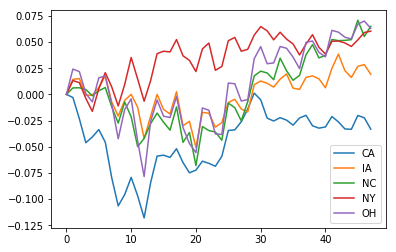

In [88]:
for state in a.index:
    print state
    plt.plot((a-b).loc[state].values)
plt.legend(a.index)
plt.show()

CA


IA


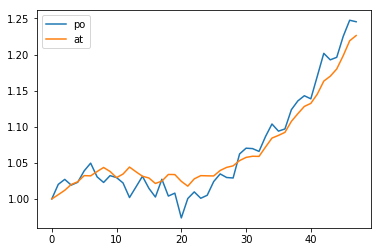

NC


NY


OH


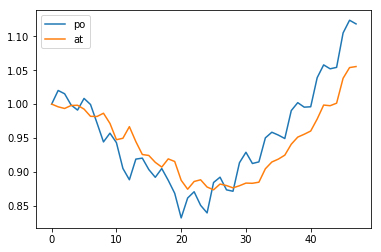

In [89]:
for state in a.index:
    print state
    plt.plot(a.loc[state].values)
    plt.plot(b.loc[state].values)
    plt.legend(['po','at'])
    plt.show()

In [77]:
a=a.diff(axis=1)
b=b.diff(axis=1)

In [78]:
a.head()

t      200601    200602    200603    200604    200701    200702    200703  \
state                                                                       
CA        NaN  0.005911 -0.017208 -0.029064 -0.008709 -0.009828 -0.047916   
IA        NaN  0.020193  0.006904 -0.007942  0.003893  0.015833  0.010694   
NC        NaN  0.020310  0.017577  0.017041  0.010450  0.015058  0.007342   
NY        NaN  0.016378 -0.002885 -0.002094 -0.007538  0.018844  0.000326   
OH        NaN  0.020146 -0.004879 -0.016587 -0.007519  0.017219 -0.009011   

t        200704    200801    200802    ...       201503    201504    201601  \
state                                  ...                                    
CA    -0.072013 -0.076980 -0.058723    ...     0.012836  0.009653  0.011926   
IA    -0.018999 -0.007735  0.009448    ...     0.012147  0.007112 -0.004257   
NC    -0.009807 -0.006752  0.018273    ...     0.020524 -0.002465  0.017845   
NY    -0.010190 -0.012749  0.001861    ...     0.018891 -0.008282 -0.001908   
OH    -0.027320 -0.027952  0.012914    ...     0.011709 -0.006658  0.000574   

t        201602    201603    201604    201701    201702    201703    201704  
state                                                                        
CA     0.025112  0.012591  0.007100  0.017977  0.035115  0.015949  0.005281  
IA     0.031354  0.031613 -0.008980  0.003478  0.028966  0.022373 -0.002076  
NC     0.031617  0.021971  0.006913  0.008949  0.059750 -0.003590  0.014576  
NY     0.029081  0.014238  0.008794  0.002466  0.023590  0.027173  0.009213  
OH     0.042989  0.018940 -0.005797  0.002124  0.050852  0.018826 -0.005395  

[5 rows x 48 columns]

In [79]:
b.head()

t      200601    200602    200603    200604    200701    200702    200703  \
state                                                                       
CA        NaN  0.008926  0.003122 -0.006212 -0.014212 -0.016879 -0.035923   
IA        NaN  0.005908  0.006075  0.008045  0.003729  0.008547 -0.000335   
NC        NaN  0.014183  0.017396  0.018727  0.016390  0.010256  0.004317   
NY        NaN  0.003202 -0.000888  0.012967  0.004787 -0.002790 -0.014981   
OH        NaN -0.004007 -0.002472  0.004419  0.000337 -0.005693 -0.010674   

t        200704    200801    200802    ...       201503    201504    201601  \
state                                  ...                                    
CA    -0.037915 -0.050213 -0.069539    ...     0.022840  0.011922  0.010745   
IA     0.005992  0.005614 -0.005531    ...     0.010684  0.010014  0.004190   
NC     0.008601  0.008828 -0.001882    ...     0.010905  0.010224  0.015222   
NY     0.003472  0.005390 -0.018706    ...     0.009987  0.003820  0.004455   
OH    -0.000225  0.004794 -0.015019    ...     0.010487  0.004232  0.004757   

t        201602    201603    201604    201701    201702    201703    201704  
state                                                                        
CA     0.015185  0.017726  0.013804  0.018338  0.021930  0.018150  0.016142  
IA     0.012821  0.018017  0.006788  0.010014  0.018394  0.020656  0.007249  
NC     0.016617  0.023044  0.006653  0.008309  0.041187  0.011911  0.004836  
NY     0.016883  0.014014  0.010574  0.005850  0.017343  0.020148  0.007894  
OH     0.017715  0.020674 -0.000974  0.003745  0.036779  0.015843  0.001536  

[5 rows x 48 columns]

CA
IA
NC
NY
OH


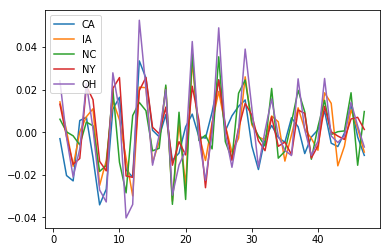

In [83]:
for state in a.index:
    print state
    plt.plot((a-b).loc[state].values)
plt.legend(a.index)
plt.show()

CA


IA


NC


NY


OH


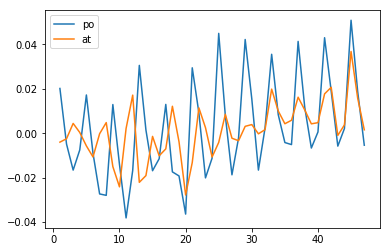

In [82]:
for state in a.index:
    print state
    plt.plot(a.loc[state].values)
    plt.plot(b.loc[state].values)
    plt.legend(['po','at'])
    plt.show()